In [1]:
import os
import json
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

# 日本語フォントの設定（macOS用）
plt.rcParams['font.family'] = 'Hiragino Sans'
# もし上記でうまくいかない場合は、以下を試してください：
# plt.rcParams['font.family'] = 'Yu Gothic'
# または
# plt.rcParams['font.family'] = 'AppleGothic'


In [2]:
age_hist = np.loadtxt('./age_hist10000.csv', delimiter=',')
print(age_hist.shape)
age_hist = np.round(age_hist, 0).astype(int)
print(age_hist)

(101, 2)
[[30 28]
 [31 30]
 [33 31]
 [34 33]
 [34 33]
 [36 34]
 [38 36]
 [39 37]
 [41 39]
 [42 40]
 [42 39]
 [42 41]
 [43 41]
 [44 42]
 [44 42]
 [44 42]
 [45 43]
 [45 43]
 [45 43]
 [47 44]
 [49 47]
 [50 47]
 [53 49]
 [54 51]
 [55 51]
 [54 51]
 [55 51]
 [54 51]
 [54 51]
 [54 51]
 [54 51]
 [53 50]
 [53 50]
 [52 50]
 [53 51]
 [54 52]
 [56 53]
 [57 54]
 [58 55]
 [59 57]
 [61 59]
 [62 60]
 [62 60]
 [62 61]
 [65 63]
 [67 65]
 [69 67]
 [71 69]
 [74 72]
 [77 75]
 [81 79]
 [82 81]
 [81 79]
 [78 77]
 [76 75]
 [74 74]
 [72 72]
 [72 72]
 [56 56]
 [69 69]
 [64 65]
 [62 63]
 [60 61]
 [58 60]
 [58 60]
 [59 61]
 [57 59]
 [55 58]
 [57 61]
 [58 62]
 [58 62]
 [60 66]
 [62 70]
 [65 73]
 [68 78]
 [73 85]
 [71 84]
 [65 79]
 [39 49]
 [40 52]
 [47 63]
 [44 60]
 [43 60]
 [39 57]
 [33 50]
 [27 42]
 [26 43]
 [24 42]
 [22 40]
 [18 35]
 [14 31]
 [12 28]
 [10 24]
 [ 7 21]
 [ 5 17]
 [ 4 14]
 [ 3 11]
 [ 2  7]
 [ 1  5]
 [ 1  4]
 [ 1  6]]


In [3]:
income_age_list = [
    {
        "age": [0, 10],  # [min, max]
        "income": [0, 0]  # [male, female]
    },
    {
        "age": [10, 20],
        "income": [144, 96],
        "income_household_var4": 0.3  # 世帯収入の四分位分散係数
    },
    {
        "age": [20, 25],
        "income": [295, 258],
        "income_household_var4": 0.3
    },
    {
        "age": [25, 30],
        "income": [438, 370],
        "income_household_var4": 0.3
    },
    {
        "age": [30, 35],
        "income": [512, 362],
        "income_household_var4": 0.32
    },
    {
        "age": [35, 40],
        "income": [574, 351],
        "income_household_var4": 0.32
    },
    {
        "age": [40, 45],
        "income": [630, 359],
        "income_household_var4": 0.38
    },
    {
        "age": [45, 50],
        "income": [663, 369],
        "income_household_var4": 0.38
    },
    {
        "age": [50, 55],
        "income": [709, 363],
        "income_household_var4": 0.47
    },
    {
        "age": [55, 60],
        "income": [735, 356],
        "income_household_var4": 0.47
    },
    {
        "age": [60, 65],
        "income": [604, 294],
        "income_household_var4": 0.55
    },
    {
        "age": [65, 70],
        "income": [472, 240],
        "income_household_var4": 0.55
    },
    {
        "age": [70, 75],
        "income": [380, 209],
        "income_household_var4": 0.55
    },
    {
        "age": [75, 120],
        "income": [380, 209],
        "income_household_var4": 0.50
    }
]

## 標準正規分布の75%分位点について

**標準正規分布**とは、平均0、標準偏差1の正規分布です。

**75%分位点（第3四分位数）**とは：
- データの75%がその値以下になるような値
- 標準正規分布では、この値は約 **0.6745** です

### 視覚的な理解

標準正規分布の確率密度関数（ベルカーブ）を考えると：
- 平均（0）を中心に左右対称
- 75%分位点（約0.6745）は、平均から右側に0.6745標準偏差離れた位置
- この位置より左側の面積が全体の75%を占める

### 四分位範囲（IQR）との関係

- **第1四分位数（25%分位点）**: 約 -0.6745（平均から左に0.6745標準偏差）
- **第3四分位数（75%分位点）**: 約 +0.6745（平均から右に0.6745標準偏差）
- **IQR = 第3四分位数 - 第1四分位数 = 0.6745 - (-0.6745) = 1.349**

一般の正規分布（平均μ、標準偏差σ）では：
- IQR = 1.349 × σ


In [6]:
# 標準正規分布の75%分位点を計算して確認
z_75 = stats.norm.ppf(0.75)
z_25 = stats.norm.ppf(0.25)

print(f"25%分位点（第1四分位数）: {z_25:.6f}")
print(f"75%分位点（第3四分位数）: {z_75:.6f}")
print(f"四分位範囲（IQR）: {z_75 - z_25:.6f}")
print(f"\n確認: 2 × z_75 = {2 * z_75:.6f} ≈ IQR")

# 実際に確率を確認
prob_75 = stats.norm.cdf(z_75)  # 75%分位点以下の確率
prob_25 = stats.norm.cdf(z_25)  # 25%分位点以下の確率

print(f"\n確率の確認:")
print(f"P(Z ≤ {z_75:.4f}) = {prob_75:.4f} (75%)")
print(f"P(Z ≤ {z_25:.4f}) = {prob_25:.4f} (25%)")


25%分位点（第1四分位数）: -0.674490
75%分位点（第3四分位数）: 0.674490
四分位範囲（IQR）: 1.348980

確認: 2 × z_75 = 1.348980 ≈ IQR

確率の確認:
P(Z ≤ 0.6745) = 0.7500 (75%)
P(Z ≤ -0.6745) = 0.2500 (25%)


In [7]:

def calculate_std_from_quartile_coefficient(mean_val, var4):
    """
    平均mean_valの正規分布に対して、四分位分散係数がvar4になるような標準偏差を算出
    
    四分位分散係数 = IQR / 中央値 = IQR / 平均
    正規分布では IQR = 2 * z_0.75 * std
    ここで z_0.75 は標準正規分布の75%分位点（約0.6745）
    
    Parameters:
    -----------
    mean_val : float
        正規分布の平均値
    var4 : float
        四分位分散係数（IQR / 平均）
    
    Returns:
    --------
    float
        標準偏差
    """
    # 標準正規分布の75%分位点
    z_75 = stats.norm.ppf(0.75)
    # IQR = 2 * z_75 * std
    # var4 = IQR / mean_val = (2 * z_75 * std) / mean_val
    # したがって: std = (var4 * mean_val) / (2 * z_75)
    std = (var4 * mean_val) / (2 * z_75)
    return std

# 使用例
# mean_val = 100
# var4 = 0.5
# std = calculate_std_from_quartile_coefficient(mean_val, var4)


In [4]:
def get_lognormal_dist_with_mean_var4(mean_target, var4_target):
    """
    平均と四分位分散係数を指定した対数正規分布の分布オブジェクトを取得
    
    対数正規分布のパラメータ（μ, σ）を、指定された平均と四分位分散係数から
    数値最適化で求める。
    
    Parameters:
    -----------
    mean_target : float
        目標とする平均値（> 0）
    var4_target : float
        目標とする四分位分散係数（IQR / 中央値）
    
    Returns:
    --------
    scipy.stats.rv_continuous
        最適化された対数正規分布の分布オブジェクト
    """
    
    # 標準正規分布の分位点
    z_25 = stats.norm.ppf(0.25)
    z_75 = stats.norm.ppf(0.75)
    
    def objective(params):
        """最適化の目的関数：平均と四分位分散係数の相対誤差の二乗和"""
        mu, sigma = params
        
        # σが負の値にならないように制約
        if sigma <= 0:
            return np.inf
        
        # 対数正規分布の平均
        mean_actual = np.exp(mu + sigma**2 / 2)
        
        # 対数正規分布の中央値
        median_actual = np.exp(mu)
        
        # 対数正規分布の分位点
        q25 = np.exp(mu + z_25 * sigma)
        q75 = np.exp(mu + z_75 * sigma)
        iqr = q75 - q25
        
        # 四分位分散係数 = IQR / 中央値
        var4_actual = iqr / median_actual if median_actual > 0 else np.inf
        
        # 相対誤差の二乗和（スケールを正規化）
        error_mean = ((mean_actual - mean_target) / mean_target)**2
        error_var4 = ((var4_actual - var4_target) / var4_target)**2 if var4_target > 0 else (var4_actual - var4_target)**2
        
        return error_mean + error_var4
    
    # 初期値の推定
    # 簡易的な初期値：σを小さく仮定してμを推定
    sigma_init = 0.5
    mu_init = np.log(mean_target) - sigma_init**2 / 2
    
    # 最適化（複数の手法を試す）
    methods = ['L-BFGS-B', 'BFGS', 'Nelder-Mead']
    result = None
    
    for method in methods:
        try:
            if method == 'L-BFGS-B':
                # L-BFGS-Bは境界制約をサポート
                result = minimize(
                    objective,
                    x0=[mu_init, sigma_init],
                    method=method,
                    bounds=[(None, None), (1e-6, None)],  # mu: 制約なし, sigma: 正の値
                    options={'maxiter': 2000, 'ftol': 1e-9}
                )
            else:
                result = minimize(
                    objective,
                    x0=[mu_init, sigma_init],
                    method=method,
                    options={'maxiter': 2000, 'ftol': 1e-9}
                )
            
            # 結果を検証
            if result.success:
                mu_test, sigma_test = result.x
                if sigma_test > 0:
                    # 実際の値を計算して確認
                    mean_test = np.exp(mu_test + sigma_test**2 / 2)
                    median_test = np.exp(mu_test)
                    q25_test = np.exp(mu_test + z_25 * sigma_test)
                    q75_test = np.exp(mu_test + z_75 * sigma_test)
                    var4_test = (q75_test - q25_test) / median_test
                    
                    # 許容誤差内かチェック
                    if abs(mean_test - mean_target) / mean_target < 0.01 and abs(var4_test - var4_target) / var4_target < 0.01:
                        break
        except:
            continue
    
    if result is None or not result.success:
        # 最後の試行結果でも許容する（警告付き）
        if result is None:
            raise ValueError("最適化に失敗しました: すべての手法が失敗しました")
        # 結果が得られた場合は警告を出して続行
        import warnings
        warnings.warn(f"最適化が完全に収束しませんでした: {result.message}。結果を使用します。")
    
    mu_opt, sigma_opt = result.x
    
    # 対数正規分布の分布オブジェクトを返す
    # scipy.stats.lognormのパラメータ: s=σ, scale=exp(μ)
    dist = stats.lognorm(s=sigma_opt, scale=np.exp(mu_opt))
    
    return dist


実際の平均: 499.85
実際の中央値: 487.60
実際の四分位分散係数: 0.2989


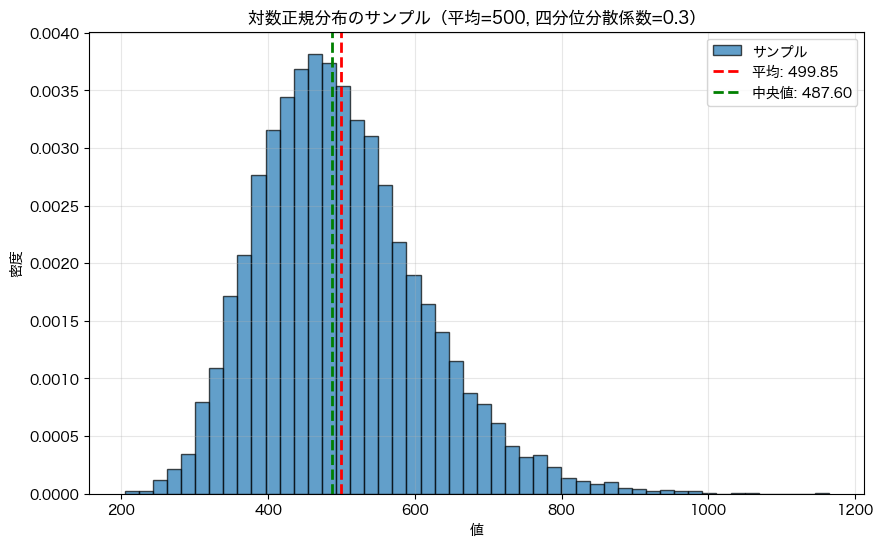

In [19]:
# 分布オブジェクトを取得してサンプリング
# 例: 平均500、四分位分散係数0.3の対数正規分布
dist = get_lognormal_dist_with_mean_var4(mean_target=500, var4_target=0.3)

# 分布オブジェクトを使ってサンプリング
samples = dist.rvs(size=10000, random_state=42)

# 検証
print(f"実際の平均: {np.mean(samples):.2f}")
print(f"実際の中央値: {np.median(samples):.2f}")
print(f"実際の四分位分散係数: {(np.percentile(samples, 75) - np.percentile(samples, 25)) / np.median(samples):.4f}")
# print(f"\n分布のパラメータ:")
# print(f"  σ (shape): {dist.args[0]:.6f}")
# print(f"  scale (exp(μ)): {dist.kwds['scale']:.6f}")

# ヒストグラムを描画
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.7, edgecolor='black', label='サンプル')
plt.axvline(np.mean(samples), color='red', linestyle='--', linewidth=2, label=f'平均: {np.mean(samples):.2f}')
plt.axvline(np.median(samples), color='green', linestyle='--', linewidth=2, label=f'中央値: {np.median(samples):.2f}')
plt.xlabel('値')
plt.ylabel('密度')
plt.title('対数正規分布のサンプル（平均=500, 四分位分散係数=0.3）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
# 個人データの生成
persons = []

for idx, age_group in enumerate(income_age_list):
    age_min, age_max = age_group['age']
    income_male, income_female = age_group['income']
    
    # その年代の男女別総人数をage_histから算出
    # age_hist[age, 0]が男性、age_hist[age, 1]が女性
    total_male = 0
    total_female = 0
    age_list_male = []  # 年齢を保持
    age_list_female = []
    
    for age in range(age_min, min(age_max + 1, age_hist.shape[0])):
        n_male = age_hist[age, 0]
        n_female = age_hist[age, 1]
        total_male += n_male
        total_female += n_female
        # 年齢を人数分だけ追加
        age_list_male.extend([age] * n_male)
        age_list_female.extend([age] * n_female)
    
    print(f"\n年代: {age_min}-{age_max}歳")
    print(f"  男性: {total_male}人, 女性: {total_female}人")
    
    # 男性の収入をサンプリング
    if income_male == 0:
        incomes_male = [0] * total_male
        print(f"  男性平均収入: 0 (全員0)")
    else:
        var4 = age_group.get('income_household_var4', 0.3)  # デフォルト値
        dist_male = get_lognormal_dist_with_mean_var4(mean_target=income_male, var4_target=var4)
        incomes_male = dist_male.rvs(size=total_male, random_state=1000 + idx * 2).tolist()
        
        # 最適化結果を確認
        samples_check = np.array(incomes_male)
        actual_mean = np.mean(samples_check)
        actual_median = np.median(samples_check)
        actual_var4 = (np.percentile(samples_check, 75) - np.percentile(samples_check, 25)) / actual_median
        
        print(f"  男性平均収入:")
        print(f"    目標: {income_male:.2f}, 実際: {actual_mean:.2f}")
        print(f"    目標四分位分散係数: {var4:.4f}, 実際: {actual_var4:.4f}")
    
    # 女性の収入をサンプリング
    if income_female == 0:
        incomes_female = [0] * total_female
        print(f"  女性平均収入: 0 (全員0)")
    else:
        var4 = age_group.get('income_household_var4', 0.3)  # デフォルト値
        dist_female = get_lognormal_dist_with_mean_var4(mean_target=income_female, var4_target=var4)
        incomes_female = dist_female.rvs(size=total_female, random_state=1000 + idx * 2 + 1).tolist()
        
        # 最適化結果を確認
        samples_check = np.array(incomes_female)
        actual_mean = np.mean(samples_check)
        actual_median = np.median(samples_check)
        actual_var4 = (np.percentile(samples_check, 75) - np.percentile(samples_check, 25)) / actual_median
        
        print(f"  女性平均収入:")
        print(f"    目標: {income_female:.2f}, 実際: {actual_mean:.2f}")
        print(f"    目標四分位分散係数: {var4:.4f}, 実際: {actual_var4:.4f}")
    
    # 個人データを追加
    for i in range(total_male):
        persons.append({
            'sex': 'male',
            'age': age_list_male[i],
            'income': max(0, round(incomes_male[i], 2))  # 負の値を0に、小数点2桁で丸める
        })
    
    for i in range(total_female):
        persons.append({
            'sex': 'female',
            'age': age_list_female[i],
            'income': max(0, round(incomes_female[i], 2))  # 負の値を0に、小数点2桁で丸める
        })

print(f"\n合計人数: {len(persons)}人")

# JSONとして保存
with open('persons.json', 'w', encoding='utf-8') as f:
    json.dump(persons, f, ensure_ascii=False, indent=2)

print(f"個人データを'persons.json'に保存しました。")



年代: 0-10歳
  男性: 400人, 女性: 380人
  男性平均収入: 0 (全員0)
  女性平均収入: 0 (全員0)

年代: 10-20歳
  男性: 490人, 女性: 467人
  男性平均収入:
    目標: 144.00, 実際: 141.54
    目標四分位分散係数: 0.3000, 実際: 0.3106
  女性平均収入:
    目標: 96.00, 実際: 95.93
    目標四分位分散係数: 0.3000, 実際: 0.3193

年代: 20-25歳
  男性: 315人, 女性: 296人
  男性平均収入:
    目標: 295.00, 実際: 299.34
    目標四分位分散係数: 0.3000, 実際: 0.3031
  女性平均収入:
    目標: 258.00, 実際: 256.22
    目標四分位分散係数: 0.3000, 実際: 0.3029

年代: 25-30歳
  男性: 325人, 女性: 306人
  男性平均収入:
    目標: 438.00, 実際: 435.56
    目標四分位分散係数: 0.3000, 実際: 0.2868
  女性平均収入:
    目標: 370.00, 実際: 368.64
    目標四分位分散係数: 0.3000, 実際: 0.2777

年代: 30-35歳
  男性: 319人, 女性: 304人
  男性平均収入:
    目標: 512.00, 実際: 493.54
    目標四分位分散係数: 0.3200, 実際: 0.2974
  女性平均収入:
    目標: 362.00, 実際: 357.57
    目標四分位分散係数: 0.3200, 実際: 0.3387

年代: 35-40歳
  男性: 345人, 女性: 330人
  男性平均収入:
    目標: 574.00, 実際: 572.86
    目標四分位分散係数: 0.3200, 実際: 0.3101
  女性平均収入:
    目標: 351.00, 実際: 350.06
    目標四分位分散係数: 0.3200, 実際: 0.3079

年代: 40-45歳
  男性: 379人, 女性: 368人
  男性平均収入:
    目標: 630.00, 

In [27]:
# 男女別平均収入の算出
male_incomes = [p['income'] for p in persons if p['sex'] == 'male']
female_incomes = [p['income'] for p in persons if p['sex'] == 'female']

male_mean = np.mean(male_incomes)
female_mean = np.mean(female_incomes)

print(f"男性の平均収入: {male_mean:.2f}")
print(f"女性の平均収入: {female_mean:.2f}")
print(f"\n男性の人数: {len(male_incomes)}人")
print(f"女性の人数: {len(female_incomes)}人")


男性の平均収入: 460.21
女性の平均収入: 266.47

男性の人数: 5653人
女性の人数: 5927人


In [28]:
# 10歳以下を除いた男女別平均収入の算出
male_incomes_over10 = [p['income'] for p in persons if p['sex'] == 'male' and p['age'] > 10]
female_incomes_over10 = [p['income'] for p in persons if p['sex'] == 'female' and p['age'] > 10]

male_mean_over10 = np.mean(male_incomes_over10)
female_mean_over10 = np.mean(female_incomes_over10)

print(f"10歳以下を除いた男性の平均収入: {male_mean_over10:.2f}")
print(f"10歳以下を除いた女性の平均収入: {female_mean_over10:.2f}")
print(f"\n10歳以下を除いた男性の人数: {len(male_incomes_over10)}人")
print(f"10歳以下を除いた女性の人数: {len(female_incomes_over10)}人")


10歳以下を除いた男性の平均収入: 498.14
10歳以下を除いた女性の平均収入: 286.13

10歳以下を除いた男性の人数: 5211人
10歳以下を除いた女性の人数: 5508人


In [29]:
# 20歳以下を除いた男女別平均収入の算出
male_incomes_over20 = [p['income'] for p in persons if p['sex'] == 'male' and p['age'] > 20]
female_incomes_over20 = [p['income'] for p in persons if p['sex'] == 'female' and p['age'] > 20]

male_mean_over20 = np.mean(male_incomes_over20)
female_mean_over20 = np.mean(female_incomes_over20)

print(f"20歳以下を除いた男性の平均収入: {male_mean_over20:.2f}")
print(f"20歳以下を除いた女性の平均収入: {female_mean_over20:.2f}")
print(f"\n20歳以下を除いた男性の人数: {len(male_incomes_over20)}人")
print(f"20歳以下を除いた女性の人数: {len(female_incomes_over20)}人")


20歳以下を除いた男性の平均収入: 533.99
20歳以下を除いた女性の平均収入: 302.38

20歳以下を除いた男性の人数: 4714人
20歳以下を除いた女性の人数: 5033人


In [53]:
# 世帯割当初期化

# 人口あたりの世帯数
all_population = 123_802_000
all_household = 54_825_000
household_per_population = all_household / all_population
total_household = household_per_population * len(persons)

# personsの各個人にhousehold_idを初期化（まだ付与されていないことを示す）
for person in persons:
    person['household_id'] = None

In [54]:


# 単独_65歳以上_男
single_elderly_male_ratio = 5.937072503 / 100
# 単独_65歳以上_男の世帯数
single_elderly_male_household = total_household * single_elderly_male_ratio

age_group_elderly_male = [
    {
        "age": [65, 70],  # 65歳以上70歳未満
        "count": 762
    },
    {
        "age": [70, 75],
        "count": 880
    },
    {
        "age": [75, 80],
        "count": 710
    },
    {
        "age": [80, 102],
        "count": 902
    }
]

# 1. 各年代のcountの合計を計算し、各年代の比率を算出
total_count = sum(group["count"] for group in age_group_elderly_male)
age_ratios = [group["count"] / total_count for group in age_group_elderly_male]

print("年代別比率:")
for i, (group, ratio) in enumerate(zip(age_group_elderly_male, age_ratios)):
    print(f"  {group['age'][0]}-{group['age'][1]}歳: {ratio:.4f} ({group['count']}人)")

# 2-4. 世帯IDを付与
household_id_counter = 1
random.seed(42)  # 再現性のため

# 各年代に該当する男性のインデックスを事前に取得（効率化のため）
age_group_candidates = {}
for i, group in enumerate(age_group_elderly_male):
    age_min, age_max = group["age"]
    # 該当する年代の男性のインデックスを取得
    candidates = [
        idx for idx, person in enumerate(persons)
        if person['sex'] == 'male' 
        and age_min <= person['age'] < age_max
        and person.get('household_id') is None
    ]
    age_group_candidates[i] = candidates

print(f"\n単独_65歳以上_男の世帯数: {int(single_elderly_male_household)}")

# 世帯IDを付与
for household_id in range(1, int(single_elderly_male_household) + 1):
    # 3. 世帯の年代を年代比率から確率的に決定
    age_group_idx = random.choices(
        range(len(age_group_elderly_male)),
        weights=age_ratios
    )[0]
    
    # 4. その年代に含まれるpersonをランダムに選択し、household_idを付与
    candidates = age_group_candidates[age_group_idx]
    
    if len(candidates) == 0:
        # 該当する年代に候補がいない場合は、次の年代を探す
        found = False
        for alt_idx in range(len(age_group_elderly_male)):
            alt_candidates = [
                idx for idx, person in enumerate(persons)
                if person['sex'] == 'male' 
                and age_group_elderly_male[alt_idx]['age'][0] <= person['age'] < age_group_elderly_male[alt_idx]['age'][1]
                and person.get('household_id') is None
            ]
            if len(alt_candidates) > 0:
                selected_idx = random.choice(alt_candidates)
                persons[selected_idx]['household_id'] = household_id
                # 候補リストを更新
                age_group_candidates[alt_idx].remove(selected_idx)
                found = True
                break
        
        if not found:
            print(f"警告: 世帯ID {household_id} を付与できる候補が見つかりませんでした")
        continue
    
    selected_idx = random.choice(candidates)
    persons[selected_idx]['household_id'] = household_id
    
    # 候補リストを更新（既にhousehold_idが付与された人は除外）
    age_group_candidates[age_group_idx].remove(selected_idx)

# 結果を確認
household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n世帯IDが付与された人数: {household_assigned}人")

# 年代別の付与状況を確認
print("\n年代別の付与状況:")
for i, group in enumerate(age_group_elderly_male):
    age_min, age_max = group["age"]
    assigned_count = sum(
        1 for p in persons
        if p['sex'] == 'male'
        and age_min <= p['age'] < age_max
        and p.get('household_id') is not None
    )
    print(f"  {age_min}-{age_max}歳: {assigned_count}人")

年代別比率:
  65-70歳: 0.2342 (762人)
  70-75歳: 0.2704 (880人)
  75-80歳: 0.2182 (710人)
  80-102歳: 0.2772 (902人)

単独_65歳以上_男の世帯数: 304

世帯IDが付与された人数: 304人

年代別の付与状況:
  65-70歳: 70人
  70-75歳: 83人
  75-80歳: 73人
  80-102歳: 78人


In [55]:
# 単独_65歳以上_女
single_elderly_female_ratio = 10.5371637 / 100
# 単独_65歳以上_女の世帯数
single_elderly_female_household = total_household * single_elderly_female_ratio

age_group_elderly_female = [
    {
        "age": [65, 70],  # 65歳以上70歳未満
        "count": 685
    },
    {
        "age": [70, 75],
        "count": 1134
    },
    {
        "age": [75, 80],
        "count": 1247
    },
    {
        "age": [80, 102],
        "count": 2711
    }
]

# 1. 各年代のcountの合計を計算し、各年代の比率を算出
total_count_female = sum(group["count"] for group in age_group_elderly_female)
age_ratios_female = [group["count"] / total_count_female for group in age_group_elderly_female]

print("年代別比率（女性）:")
for i, (group, ratio) in enumerate(zip(age_group_elderly_female, age_ratios_female)):
    print(f"  {group['age'][0]}-{group['age'][1]}歳: {ratio:.4f} ({group['count']}人)")

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max(
    (p.get('household_id') for p in persons if p.get('household_id') is not None),
    default=0
)
print(f"\n既存の最大household_id: {max_existing_id}")

# 各年代に該当する女性のインデックスを事前に取得（効率化のため）
age_group_candidates_female = {}
for i, group in enumerate(age_group_elderly_female):
    age_min, age_max = group["age"]
    # 該当する年代の女性のインデックスを取得
    candidates = [
        idx for idx, person in enumerate(persons)
        if person['sex'] == 'female' 
        and age_min <= person['age'] < age_max
        and person.get('household_id') is None
    ]
    age_group_candidates_female[i] = candidates

print(f"\n単独_65歳以上_女の世帯数: {int(single_elderly_female_household)}")

# 世帯IDを付与（既存のIDの次から開始）
start_household_id = max_existing_id + 1
for household_id in range(start_household_id, start_household_id + int(single_elderly_female_household)):
    # 3. 世帯の年代を年代比率から確率的に決定
    age_group_idx = random.choices(
        range(len(age_group_elderly_female)),
        weights=age_ratios_female
    )[0]
    
    # 4. その年代に含まれるpersonをランダムに選択し、household_idを付与
    candidates = age_group_candidates_female[age_group_idx]
    
    if len(candidates) == 0:
        # 該当する年代に候補がいない場合は、次の年代を探す
        found = False
        for alt_idx in range(len(age_group_elderly_female)):
            alt_candidates = [
                idx for idx, person in enumerate(persons)
                if person['sex'] == 'female' 
                and age_group_elderly_female[alt_idx]['age'][0] <= person['age'] < age_group_elderly_female[alt_idx]['age'][1]
                and person.get('household_id') is None
            ]
            if len(alt_candidates) > 0:
                selected_idx = random.choice(alt_candidates)
                persons[selected_idx]['household_id'] = household_id
                # 候補リストを更新
                age_group_candidates_female[alt_idx].remove(selected_idx)
                found = True
                break
        
        if not found:
            print(f"警告: 世帯ID {household_id} を付与できる候補が見つかりませんでした")
        continue
    
    selected_idx = random.choice(candidates)
    persons[selected_idx]['household_id'] = household_id
    
    # 候補リストを更新（既にhousehold_idが付与された人は除外）
    age_group_candidates_female[age_group_idx].remove(selected_idx)

# 結果を確認
household_assigned_female = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（女性）: {household_assigned_female}人")

# 年代別の付与状況を確認
print("\n年代別の付与状況（女性）:")
for i, group in enumerate(age_group_elderly_female):
    age_min, age_max = group["age"]
    assigned_count = sum(
        1 for p in persons
        if p['sex'] == 'female'
        and age_min <= p['age'] < age_max
        and p.get('household_id') is not None
        and p.get('household_id', 0) > max_existing_id
    )
    print(f"  {age_min}-{age_max}歳: {assigned_count}人")

# 全体の確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")

年代別比率（女性）:
  65-70歳: 0.1186 (685人)
  70-75歳: 0.1963 (1134人)
  75-80歳: 0.2159 (1247人)
  80-102歳: 0.4693 (2711人)

既存の最大household_id: 304

単独_65歳以上_女の世帯数: 540

世帯IDが付与された人数（女性）: 540人

年代別の付与状況（女性）:
  65-70歳: 69人
  70-75歳: 95人
  75-80歳: 106人
  80-102歳: 270人

全体で世帯IDが付与された人数: 844人


In [56]:
# 単独_18歳以上65歳未満_男女
single_young_ratio = 18.17419061 / 100
# 単独_18歳以上65歳未満_男女の世帯数
single_young_household = total_household * single_young_ratio

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max(
    (p.get('household_id') for p in persons if p.get('household_id') is not None),
    default=0
)
print(f"既存の最大household_id: {max_existing_id}")

# 18~65歳（65歳未満）で、まだhousehold_idが付与されていないpersonのインデックスを取得
young_candidates = [
    idx for idx, person in enumerate(persons)
    if 18 <= person['age'] < 65
    and person.get('household_id') is None
]

print(f"\n単独_18歳以上65歳未満_男女の世帯数: {int(single_young_household)}")
print(f"候補人数（18~65歳未満でhousehold_id未付与）: {len(young_candidates)}人")

# 世帯IDを付与（既存のIDの次から開始）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(single_young_household)):
    if len(young_candidates) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる候補が見つかりませんでした")
        break
    
    # 4. personsから0~65歳のpersonをランダムに選択し、household_idを付与
    selected_idx = random.choice(young_candidates)
    persons[selected_idx]['household_id'] = household_id
    
    # 候補リストから除外
    young_candidates.remove(selected_idx)
    assigned_count += 1

# 結果を確認
household_assigned_young = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（18歳以上65歳未満）: {household_assigned_young}人")

# 男女別の付与状況を確認
male_assigned = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id and p['sex'] == 'male' and 0 <= p['age'] < 65)
female_assigned = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id and p['sex'] == 'female' and 0 <= p['age'] < 65)
print(f"  男性: {male_assigned}人")
print(f"  女性: {female_assigned}人")

# 全体の確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")


既存の最大household_id: 844

単独_18歳以上65歳未満_男女の世帯数: 931
候補人数（18~65歳未満でhousehold_id未付与）: 6791人

世帯IDが付与された人数（18歳以上65歳未満）: 931人
  男性: 458人
  女性: 473人

全体で世帯IDが付与された人数: 1775人


## prompt

以下の手順で`persons`の該当する個人の属性に、世帯ごとに異なる`household_id`を付与して。
1. `age_group_elderly_male`の各年代の`count`をもとに男性の各年代の比率を算出
2. `age_group_elderly_female`の各年代の`count`をもとに女性の各年代の比率を算出
3. `couple_elderly_household`の数の分、以下を実行
4. 世帯の男女の年代を年代比率からそれぞれ確率的に決定
5. `persons`から男女それぞれその年代に含まれるpersonをランダムに選択し、同一の`household_id`を付与

In [57]:
# 夫婦_65歳以上_男女
couple_elderly_ratio = 13.67624259 / 100
# 夫婦_65歳以上_男女の世帯数
couple_elderly_household = total_household * couple_elderly_ratio

# 1. age_group_elderly_maleの各年代のcountをもとに男性の各年代の比率を算出
total_count_male = sum(group["count"] for group in age_group_elderly_male)
age_ratios_male = [group["count"] / total_count_male for group in age_group_elderly_male]

print("男性の年代別比率:")
for i, (group, ratio) in enumerate(zip(age_group_elderly_male, age_ratios_male)):
    print(f"  {group['age'][0]}-{group['age'][1]}歳: {ratio:.4f} ({group['count']}人)")

# 2. age_group_elderly_femaleの各年代のcountをもとに女性の各年代の比率を算出
total_count_female = sum(group["count"] for group in age_group_elderly_female)
age_ratios_female = [group["count"] / total_count_female for group in age_group_elderly_female]

print("\n女性の年代別比率:")
for i, (group, ratio) in enumerate(zip(age_group_elderly_female, age_ratios_female)):
    print(f"  {group['age'][0]}-{group['age'][1]}歳: {ratio:.4f} ({group['count']}人)")

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max(
    (p.get('household_id') for p in persons if p.get('household_id') is not None),
    default=0
)
print(f"\n既存の最大household_id: {max_existing_id}")

# 各年代に該当する男性・女性のインデックスを事前に取得（効率化のため）
age_group_candidates_male = {}
for i, group in enumerate(age_group_elderly_male):
    age_min, age_max = group["age"]
    candidates = [
        idx for idx, person in enumerate(persons)
        if person['sex'] == 'male' 
        and age_min <= person['age'] < age_max
        and person.get('household_id') is None
    ]
    age_group_candidates_male[i] = candidates

age_group_candidates_female = {}
for i, group in enumerate(age_group_elderly_female):
    age_min, age_max = group["age"]
    candidates = [
        idx for idx, person in enumerate(persons)
        if person['sex'] == 'female' 
        and age_min <= person['age'] < age_max
        and person.get('household_id') is None
    ]
    age_group_candidates_female[i] = candidates

print(f"\n夫婦_65歳以上_男女の世帯数: {int(couple_elderly_household)}")

# 3-5. 世帯IDを付与（既存のIDの次から開始）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(couple_elderly_household)):
    # 4. 世帯の男女の年代を年代比率からそれぞれ確率的に決定
    male_age_group_idx = random.choices(
        range(len(age_group_elderly_male)),
        weights=age_ratios_male
    )[0]
    
    female_age_group_idx = random.choices(
        range(len(age_group_elderly_female)),
        weights=age_ratios_female
    )[0]
    
    # 5. personsから男女それぞれその年代に含まれるpersonをランダムに選択し、同一のhousehold_idを付与
    male_candidates = age_group_candidates_male[male_age_group_idx]
    female_candidates = age_group_candidates_female[female_age_group_idx]
    
    # 候補がいない場合は、他の年代を探す
    if len(male_candidates) == 0:
        found = False
        for alt_idx in range(len(age_group_elderly_male)):
            alt_candidates = [
                idx for idx, person in enumerate(persons)
                if person['sex'] == 'male' 
                and age_group_elderly_male[alt_idx]['age'][0] <= person['age'] < age_group_elderly_male[alt_idx]['age'][1]
                and person.get('household_id') is None
            ]
            if len(alt_candidates) > 0:
                male_candidates = alt_candidates
                male_age_group_idx = alt_idx
                found = True
                break
        if not found:
            print(f"警告: 世帯ID {household_id} を付与できる男性候補が見つかりませんでした")
            continue
    
    if len(female_candidates) == 0:
        found = False
        for alt_idx in range(len(age_group_elderly_female)):
            alt_candidates = [
                idx for idx, person in enumerate(persons)
                if person['sex'] == 'female' 
                and age_group_elderly_female[alt_idx]['age'][0] <= person['age'] < age_group_elderly_female[alt_idx]['age'][1]
                and person.get('household_id') is None
            ]
            if len(alt_candidates) > 0:
                female_candidates = alt_candidates
                female_age_group_idx = alt_idx
                found = True
                break
        if not found:
            print(f"警告: 世帯ID {household_id} を付与できる女性候補が見つかりませんでした")
            continue
    
    # ランダムに選択
    selected_male_idx = random.choice(male_candidates)
    selected_female_idx = random.choice(female_candidates)
    
    # 同一のhousehold_idを付与
    persons[selected_male_idx]['household_id'] = household_id
    persons[selected_female_idx]['household_id'] = household_id
    
    # 候補リストを更新
    age_group_candidates_male[male_age_group_idx].remove(selected_male_idx)
    age_group_candidates_female[female_age_group_idx].remove(selected_female_idx)
    
    assigned_count += 1

# 結果を確認
household_assigned_couple = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（夫婦_65歳以上）: {household_assigned_couple}人")
print(f"  世帯数: {assigned_count}世帯（1世帯あたり2人）")

# 年代別の付与状況を確認
print("\n男性の年代別付与状況:")
for i, group in enumerate(age_group_elderly_male):
    age_min, age_max = group["age"]
    assigned_count = sum(
        1 for p in persons
        if p['sex'] == 'male'
        and age_min <= p['age'] < age_max
        and p.get('household_id') is not None
        and p.get('household_id', 0) > max_existing_id
    )
    print(f"  {age_min}-{age_max}歳: {assigned_count}人")

print("\n女性の年代別付与状況:")
for i, group in enumerate(age_group_elderly_female):
    age_min, age_max = group["age"]
    assigned_count = sum(
        1 for p in persons
        if p['sex'] == 'female'
        and age_min <= p['age'] < age_max
        and p.get('household_id') is not None
        and p.get('household_id', 0) > max_existing_id
    )
    print(f"  {age_min}-{age_max}歳: {assigned_count}人")

# 全体の確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")



男性の年代別比率:
  65-70歳: 0.2342 (762人)
  70-75歳: 0.2704 (880人)
  75-80歳: 0.2182 (710人)
  80-102歳: 0.2772 (902人)

女性の年代別比率:
  65-70歳: 0.1186 (685人)
  70-75歳: 0.1963 (1134人)
  75-80歳: 0.2159 (1247人)
  80-102歳: 0.4693 (2711人)

既存の最大household_id: 1775

夫婦_65歳以上_男女の世帯数: 701

世帯IDが付与された人数（夫婦_65歳以上）: 1402人
  世帯数: 701世帯（1世帯あたり2人）

男性の年代別付与状況:
  65-70歳: 157人
  70-75歳: 200人
  75-80歳: 149人
  80-102歳: 195人

女性の年代別付与状況:
  65-70歳: 84人
  70-75歳: 128人
  75-80歳: 163人
  80-102歳: 326人

全体で世帯IDが付与された人数: 3177人


## prompt
以下の手順で`persons`の該当する個人の属性に、世帯ごとに異なる`household_id`を付与して。
1. `couple_elderly_young_household`の数の分、以下を実行
2. `persons`から男女のいずれかに対し60~64歳に含まれるpersonをランダムに選択し、他方の性別に対し65~69歳に含まれるpersonをランダムに選択し、同一の`household_id`を付与

In [58]:
# 夫婦_65歳前後_男女
couple_elderly_young_ratio = 2.349293206 / 100
# 夫婦_65歳前後_男女の世帯数
couple_elderly_young_household = total_household * couple_elderly_young_ratio

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max(
    (p.get('household_id') for p in persons if p.get('household_id') is not None),
    default=0
)
print(f"既存の最大household_id: {max_existing_id}")

# 60~64歳で、まだhousehold_idが付与されていないpersonのインデックスを取得
candidates_60_64_male = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'male'
    and 60 <= person['age'] < 65
    and person.get('household_id') is None
]

candidates_60_64_female = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'female'
    and 60 <= person['age'] < 65
    and person.get('household_id') is None
]

# 65~69歳で、まだhousehold_idが付与されていないpersonのインデックスを取得
candidates_65_69_male = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'male'
    and 65 <= person['age'] < 70
    and person.get('household_id') is None
]

candidates_65_69_female = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'female'
    and 65 <= person['age'] < 70
    and person.get('household_id') is None
]

print(f"\n夫婦_65歳前後_男女の世帯数: {int(couple_elderly_young_household)}")
print(f"候補人数:")
print(f"  60~64歳 男性: {len(candidates_60_64_male)}人")
print(f"  60~64歳 女性: {len(candidates_60_64_female)}人")
print(f"  65~69歳 男性: {len(candidates_65_69_male)}人")
print(f"  65~69歳 女性: {len(candidates_65_69_female)}人")

# 1-2. 世帯IDを付与（既存のIDの次から開始）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(couple_elderly_young_household)):
    # 2. 男女のいずれかをランダムに決定（どちらが60~64歳になるか）
    first_sex = random.choice(['male', 'female'])
    
    if first_sex == 'male':
        # 男性が60~64歳、女性が65~69歳
        candidates_60_64 = candidates_60_64_male
        candidates_65_69 = candidates_65_69_female
    else:
        # 女性が60~64歳、男性が65~69歳
        candidates_60_64 = candidates_60_64_female
        candidates_65_69 = candidates_65_69_male
    
    # 候補がいない場合は、逆の組み合わせを試す
    if len(candidates_60_64) == 0 or len(candidates_65_69) == 0:
        # 逆の組み合わせを試す
        if first_sex == 'male':
            candidates_60_64 = candidates_60_64_female
            candidates_65_69 = candidates_65_69_male
        else:
            candidates_60_64 = candidates_60_64_male
            candidates_65_69 = candidates_65_69_female
        
        if len(candidates_60_64) == 0 or len(candidates_65_69) == 0:
            print(f"警告: 世帯ID {household_id} を付与できる候補が見つかりませんでした")
            continue
    
    # ランダムに選択
    selected_60_64_idx = random.choice(candidates_60_64)
    selected_65_69_idx = random.choice(candidates_65_69)
    
    # 同一のhousehold_idを付与
    persons[selected_60_64_idx]['household_id'] = household_id
    persons[selected_65_69_idx]['household_id'] = household_id
    
    # 候補リストから除外
    if first_sex == 'male':
        candidates_60_64_male.remove(selected_60_64_idx)
        candidates_65_69_female.remove(selected_65_69_idx)
    else:
        candidates_60_64_female.remove(selected_60_64_idx)
        candidates_65_69_male.remove(selected_65_69_idx)
    
    assigned_count += 1

# 結果を確認
household_assigned_couple_ey = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（夫婦_65歳前後）: {household_assigned_couple_ey}人")
print(f"  世帯数: {assigned_count}世帯（1世帯あたり2人）")

# 年齢別・性別の付与状況を確認
male_60_64 = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id and p['sex'] == 'male' and 60 <= p['age'] < 65)
female_60_64 = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id and p['sex'] == 'female' and 60 <= p['age'] < 65)
male_65_69 = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id and p['sex'] == 'male' and 65 <= p['age'] < 70)
female_65_69 = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id and p['sex'] == 'female' and 65 <= p['age'] < 70)

print(f"\n年齢別・性別の付与状況:")
print(f"  60~64歳 男性: {male_60_64}人")
print(f"  60~64歳 女性: {female_60_64}人")
print(f"  65~69歳 男性: {male_65_69}人")
print(f"  65~69歳 女性: {female_65_69}人")

# 全体の確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")

既存の最大household_id: 2476

夫婦_65歳前後_男女の世帯数: 120
候補人数:
  60~64歳 男性: 316人
  60~64歳 女性: 327人
  65~69歳 男性: 118人
  65~69歳 女性: 209人

世帯IDが付与された人数（夫婦_65歳前後）: 240人
  世帯数: 120世帯（1世帯あたり2人）

年齢別・性別の付与状況:
  60~64歳 男性: 61人
  60~64歳 女性: 59人
  65~69歳 男性: 59人
  65~69歳 女性: 61人

全体で世帯IDが付与された人数: 3417人


## prompt
以下の手順で`persons`の該当する個人の属性に、世帯ごとに異なる`household_id`を付与して。
1. `couple_young_household`の数の分、以下を実行
2. `persons`から男女それぞれそ18~64歳に含まれるpersonをランダムに選択し、同一の`household_id`を付与

In [59]:
# 夫婦_65歳未満_男女
couple_young_ratio = 8.680346557 / 100
# 夫婦_65歳未満_男女の世帯数
couple_young_household = total_household * couple_young_ratio


# 既に付与されている最大のhousehold_idを取得
max_existing_id = max(
    (p.get('household_id') for p in persons if p.get('household_id') is not None),
    default=0
)
print(f"既存の最大household_id: {max_existing_id}")

# 18~64歳で、まだhousehold_idが付与されていないpersonのインデックスを取得
candidates_18_64_male = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'male'
    and 18 <= person['age'] < 65
    and person.get('household_id') is None
]

candidates_18_64_female = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'female'
    and 18 <= person['age'] < 65
    and person.get('household_id') is None
]

print(f"\n夫婦_65歳未満_男女の世帯数: {int(couple_young_household)}")
print(f"候補人数:")
print(f"  18~64歳 男性: {len(candidates_18_64_male)}人")
print(f"  18~64歳 女性: {len(candidates_18_64_female)}人")

# 1-2. 世帯IDを付与（既存のIDの次から開始）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(couple_young_household)):
    # 2. personsから男女それぞれ18~64歳に含まれるpersonをランダムに選択し、同一のhousehold_idを付与
    if len(candidates_18_64_male) == 0 or len(candidates_18_64_female) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる候補が見つかりませんでした")
        break
    
    # ランダムに選択
    selected_male_idx = random.choice(candidates_18_64_male)
    selected_female_idx = random.choice(candidates_18_64_female)
    
    # 同一のhousehold_idを付与
    persons[selected_male_idx]['household_id'] = household_id
    persons[selected_female_idx]['household_id'] = household_id
    
    # 候補リストから除外
    candidates_18_64_male.remove(selected_male_idx)
    candidates_18_64_female.remove(selected_female_idx)
    
    assigned_count += 1

# 結果を確認
household_assigned_couple_young = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（夫婦_65歳未満）: {household_assigned_couple_young}人")
print(f"  世帯数: {assigned_count}世帯（1世帯あたり2人）")

# 男女別の付与状況を確認
male_assigned = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id and p['sex'] == 'male' and 18 <= p['age'] < 65)
female_assigned = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id and p['sex'] == 'female' and 18 <= p['age'] < 65)
print(f"  男性: {male_assigned}人")
print(f"  女性: {female_assigned}人")

# 全体の確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")





既存の最大household_id: 2596

夫婦_65歳未満_男女の世帯数: 445
候補人数:
  18~64歳 男性: 2925人
  18~64歳 女性: 2815人

世帯IDが付与された人数（夫婦_65歳未満）: 890人
  世帯数: 445世帯（1世帯あたり2人）
  男性: 445人
  女性: 445人

全体で世帯IDが付与された人数: 4307人


## prompt

以下の手順で`persons`の該当する個人の属性に、世帯ごとに異なる`household_id`を付与して。
1. `couple_child_small_count`の各児童人数の`count`をもとに児童人数の比率を算出
2. `couple_child_small_household`の数の分、以下を実行
3. 世帯の児童人数を算出した比率からそれぞれ確率的に決定
4. `persons`から18歳以上65歳未満の男女、決定された人数分の18歳未満をランダムに選択し、`household_id`を付与

In [60]:
# 夫婦と未婚の子(児童あり)
couple_child_small_ratio = 13.10168719 / 100
# 夫婦と未婚の子(児童あり)の世帯数
couple_child_small_household = total_household * couple_child_small_ratio

couple_child_small_count = [
    {
        "num_child": 1, 
        "count": 3264
    },
    {
        "num_child": 2,  
        "count": 2953
    },
    {
        "num_child": 3,  
        "count": 829
    },
    {
        "num_child": 4, 
        "count": 137
    }
]

# 1. couple_child_small_countの各児童人数のcountをもとに児童人数の比率を算出
total_count_child = sum(group["count"] for group in couple_child_small_count)
child_num_ratios = [group["count"] / total_count_child for group in couple_child_small_count]

print("児童人数別比率:")
for i, (group, ratio) in enumerate(zip(couple_child_small_count, child_num_ratios)):
    print(f"  {group['num_child']}人: {ratio:.4f} ({group['count']}世帯)")

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max(
    (p.get('household_id') for p in persons if p.get('household_id') is not None),
    default=0
)
print(f"\n既存の最大household_id: {max_existing_id}")

# 18歳以上55歳未満で、まだhousehold_idが付与されていないpersonのインデックスを取得
candidates_18_54_male = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'male'
    and 18 <= person['age'] < 55
    and person.get('household_id') is None
]

candidates_18_54_female = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'female'
    and 18 <= person['age'] < 55
    and person.get('household_id') is None
]

# 18歳未満で、まだhousehold_idが付与されていないpersonのインデックスを取得
candidates_under18 = [
    idx for idx, person in enumerate(persons)
    if person['age'] < 18
    and person.get('household_id') is None
]

print(f"\n夫婦と未婚の子(児童あり)の世帯数: {int(couple_child_small_household)}")
print(f"候補人数:")
print(f"  18~54歳 男性: {len(candidates_18_54_male)}人")
print(f"  18~54歳 女性: {len(candidates_18_54_female)}人")
print(f"  18歳未満: {len(candidates_under18)}人")

# 2-4. 世帯IDを付与（既存のIDの次から開始）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(couple_child_small_household)):
    # 3. 世帯の児童人数を算出した比率からそれぞれ確率的に決定
    child_num_idx = random.choices(
        range(len(couple_child_small_count)),
        weights=child_num_ratios
    )[0]
    num_child = couple_child_small_count[child_num_idx]["num_child"]
    
    # 4. personsから18歳以上65歳未満の男女、決定された人数分の18歳未満をランダムに選択し、household_idを付与
    if len(candidates_18_54_male) == 0 or len(candidates_18_54_female) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる大人の候補が見つかりませんでした")
        break
    
    if len(candidates_under18) < num_child:
        print(f"警告: 世帯ID {household_id} を付与できる児童の候補が不足しています（必要: {num_child}人、利用可能: {len(candidates_under18)}人）")
        break
    
    # ランダムに選択
    selected_male_idx = random.choice(candidates_18_54_male)
    selected_female_idx = random.choice(candidates_18_54_female)
    selected_child_indices = random.sample(candidates_under18, num_child)
    
    # 同一のhousehold_idを付与
    persons[selected_male_idx]['household_id'] = household_id
    persons[selected_female_idx]['household_id'] = household_id
    for child_idx in selected_child_indices:
        persons[child_idx]['household_id'] = household_id
    
    # 候補リストから除外
    candidates_18_54_male.remove(selected_male_idx)
    candidates_18_54_female.remove(selected_female_idx)
    for child_idx in selected_child_indices:
        candidates_under18.remove(child_idx)
    
    assigned_count += 1

# 結果を確認
household_assigned_couple_child = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（夫婦と未婚の子）: {household_assigned_couple_child}人")
print(f"  世帯数: {assigned_count}世帯")

# 児童人数別の付与状況を確認
print("\n児童人数別の付与状況:")
for group in couple_child_small_count:
    num_child = group["num_child"]
    # この児童人数の世帯数を計算（実際に付与された世帯数から推定）
    # 実際の実装では、各世帯の児童人数を記録する必要があるが、ここでは簡易的に確認
    print(f"  {num_child}人: （確認用）")

# 全体の確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")


児童人数別比率:
  1人: 0.4544 (3264世帯)
  2人: 0.4111 (2953世帯)
  3人: 0.1154 (829世帯)
  4人: 0.0191 (137世帯)

既存の最大household_id: 3041

夫婦と未婚の子(児童あり)の世帯数: 671
候補人数:
  18~54歳 男性: 1950人
  18~54歳 女性: 1856人
  18歳未満: 1462人

世帯IDが付与された人数（夫婦と未婚の子）: 2480人
  世帯数: 671世帯

児童人数別の付与状況:
  1人: （確認用）
  2人: （確認用）
  3人: （確認用）
  4人: （確認用）

全体で世帯IDが付与された人数: 6787人


## prompt

以下の手順で`persons`の該当する個人の属性に、世帯ごとに異なる`household_id`を付与して。
1. `couple_child_large_household`の数の分、以下を実行
2. `persons`から65歳以上の男女、18歳以上65歳未満の1人をランダムに選択し、`household_id`を付与

In [61]:
# 夫婦と未婚の子(児童なし)
couple_child_large_ratio = 11.00775194 / 100
# 夫婦と未婚の子(児童なし)の世帯数
couple_child_large_household = total_household * couple_child_large_ratio

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max(
    (p.get('household_id') for p in persons if p.get('household_id') is not None),
    default=0
)
print(f"既存の最大household_id: {max_existing_id}")

# 60歳以上で、まだhousehold_idが付与されていないpersonのインデックスを取得
candidates_55plus_male = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'male'
    and person['age'] >= 55
    and person.get('household_id') is None
]

candidates_55plus_female = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'female'
    and person['age'] >= 55
    and person.get('household_id') is None
]

# 18歳以上55歳未満で、まだhousehold_idが付与されていないpersonのインデックスを取得
candidates_18plus_under55 = [
    idx for idx, person in enumerate(persons)
    if 18 <=person['age'] < 55
    and person.get('household_id') is None
]

print(f"\n夫婦と未婚の子(児童なし)の世帯数: {int(couple_child_large_household)}")
print(f"候補人数:")
print(f"  60歳以上 男性: {len(candidates_55plus_male)}人")
print(f"  60歳以上 女性: {len(candidates_55plus_female)}人")
print(f"  18歳以上60歳未満: {len(candidates_18plus_under55)}人")

# 1-2. 世帯IDを付与（既存のIDの次から開始）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(couple_child_large_household)):
    # 2. personsから60歳以上の男女、18歳未満の1人をランダムに選択し、household_idを付与
    if len(candidates_55plus_male) == 0 or len(candidates_55plus_female) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる大人の候補が見つかりませんでした")
        break
    
    if len(candidates_18plus_under55) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる児童の候補が見つかりませんでした")
        break
    
    # ランダムに選択
    selected_male_idx = random.choice(candidates_55plus_male)
    selected_female_idx = random.choice(candidates_55plus_female)
    selected_child_idx = random.choice(candidates_18plus_under55)
    
    # 同一のhousehold_idを付与
    persons[selected_male_idx]['household_id'] = household_id
    persons[selected_female_idx]['household_id'] = household_id
    persons[selected_child_idx]['household_id'] = household_id
    
    # 候補リストから除外
    candidates_55plus_male.remove(selected_male_idx)
    candidates_55plus_female.remove(selected_female_idx)
    candidates_18plus_under55.remove(selected_child_idx)
    
    assigned_count += 1

# 結果を確認
household_assigned_couple_child_large = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（夫婦と未婚の子(児童なし)）: {household_assigned_couple_child_large}人")
print(f"  世帯数: {assigned_count}世帯（1世帯あたり3人：大人2人+子供1人）")

# 全体の確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")


既存の最大household_id: 3712

夫婦と未婚の子(児童なし)の世帯数: 564
候補人数:
  60歳以上 男性: 926人
  60歳以上 女性: 1079人
  18歳以上60歳未満: 2464人

世帯IDが付与された人数（夫婦と未婚の子(児童なし)）: 1692人
  世帯数: 564世帯（1世帯あたり3人：大人2人+子供1人）

全体で世帯IDが付与された人数: 8479人


In [49]:
len(candidates_60plus_male)

54

## prompt
以下の手順で`persons`の該当する個人の属性に、世帯ごとに異なる`household_id`を付与するようにコードに追記して。
1. `single_mother_child_small_count`の各児童人数の`count`をもとに児童人数の比率を算出
2. `single_mother_child_small_household`の数の分、以下を実行
3. 世帯の児童人数を算出した比率からそれぞれ確率的に決定
4. `persons`から18歳以上60歳未満の女、決定された人数分の18歳未満をランダムに選択し、`household_id`を付与

In [62]:
# ひとり親と未婚の子(母子)
single_mother_child_small_ratio = 1.076151391 / 100
# ひとり親と未婚の子(母子)の世帯数
single_mother_child_small_household = total_household * single_mother_child_small_ratio

single_mother_child_small_count = [
    {
        "num_child": 1,  # 65歳以上70歳未満
        "count": 398
    },
    {
        "num_child": 2,  # 65歳以上70歳未満
        "count": 197
    },
    {
        "num_child": 3,  # 65歳以上70歳未満
        "count": 53
    },
    {
        "num_child": 4,  # 65歳以上70歳未満
        "count": 11
    }
]

# 1. single_mother_child_small_countの各児童人数のcountをもとに児童人数の比率を算出
total_count_child_mother = sum(group["count"] for group in single_mother_child_small_count)
child_num_ratios_mother = [group["count"] / total_count_child_mother for group in single_mother_child_small_count]

print("児童人数別比率（母子）:")
for group, ratio in zip(single_mother_child_small_count, child_num_ratios_mother):
    print(f"  {group['num_child']}人: {ratio:.4f} ({group['count']}世帯)")

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max((p.get('household_id') for p in persons if p.get('household_id') is not None), default=0)
print(f"\n既存の最大household_id: {max_existing_id}")

# 18歳以上55歳未満の女性（未割当）
candidates_female_18_54 = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'female'
    and 18 <= person['age'] < 55
    and person.get('household_id') is None
]

# 18歳未満（未割当）
candidates_under18 = [
    idx for idx, person in enumerate(persons)
    if person['age'] < 18
    and person.get('household_id') is None
]

print(f"\nひとり親(母子)の世帯数: {int(single_mother_child_small_household)}")
print("候補人数:")
print(f"  女性(18~59): {len(candidates_female_18_54)}人")
print(f"  18歳未満: {len(candidates_under18)}人")

# 2-4. 世帯IDを付与（既存のIDの次から）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(single_mother_child_small_household)):
    # 3. 世帯の児童人数を確率的に決定
    child_num_idx = random.choices(
        range(len(single_mother_child_small_count)),
        weights=child_num_ratios_mother
    )[0]
    num_child = single_mother_child_small_count[child_num_idx]["num_child"]

    # 4. 母1名と児童num_child名を選択
    if len(candidates_female_18_54) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる母の候補が不足しています")
        break

    if len(candidates_under18) < num_child:
        print(f"警告: 世帯ID {household_id} を付与できる児童の候補が不足しています（必要: {num_child}人、利用可能: {len(candidates_under18)}人）")
        break

    mother_idx = random.choice(candidates_female_18_54)
    child_indices = random.sample(candidates_under18, num_child)

    # household_id を付与
    persons[mother_idx]['household_id'] = household_id
    for cidx in child_indices:
        persons[cidx]['household_id'] = household_id

    # 候補から除外
    candidates_female_18_54.remove(mother_idx)
    for cidx in child_indices:
        candidates_under18.remove(cidx)

    assigned_count += 1

# 結果確認
household_assigned_single_mother = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（ひとり親(母子)）: {household_assigned_single_mother}人")
print(f"  世帯数: {assigned_count}世帯（1世帯あたり母1人 + 子{num_child}人）")

# 全体確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")

児童人数別比率（母子）:
  1人: 0.6039 (398世帯)
  2人: 0.2989 (197世帯)
  3人: 0.0804 (53世帯)
  4人: 0.0167 (11世帯)

既存の最大household_id: 4276

ひとり親(母子)の世帯数: 55
候補人数:
  女性(18~59): 900人
  18歳未満: 324人

世帯IDが付与された人数（ひとり親(母子)）: 140人
  世帯数: 55世帯（1世帯あたり母1人 + 子2人）

全体で世帯IDが付与された人数: 8619人


In [63]:
# ひとり親と未婚の子(父子)
single_father_child_small_ratio = 0.1094391245 / 100
# ひとり親と未婚の子(父子)の世帯数
single_father_child_small_household = total_household * single_father_child_small_ratio

single_father_child_small_count = [
    {
        "num_child": 1,  # 65歳以上70歳未満
        "count": 398
    },
    {
        "num_child": 2,  # 65歳以上70歳未満
        "count": 197
    },
    {
        "num_child": 3,  # 65歳以上70歳未満
        "count": 53
    },
    {
        "num_child": 4,  # 65歳以上70歳未満
        "count": 11
    }
]

# 1. single_father_child_small_countの各児童人数のcountをもとに児童人数の比率を算出
total_count_child_father = sum(group["count"] for group in single_father_child_small_count)
child_num_ratios_father = [group["count"] / total_count_child_father for group in single_father_child_small_count]

print("児童人数別比率（父子）:")
for group, ratio in zip(single_father_child_small_count, child_num_ratios_father):
    print(f"  {group['num_child']}人: {ratio:.4f} ({group['count']}世帯)")

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max((p.get('household_id') for p in persons if p.get('household_id') is not None), default=0)
print(f"\n既存の最大household_id: {max_existing_id}")

# 18歳以上55歳未満の男性（未割当）
candidates_male_18_54 = [
    idx for idx, person in enumerate(persons)
    if person['sex'] == 'male'
    and 18 <= person['age'] < 55
    and person.get('household_id') is None
]

# 18歳未満（未割当）
candidates_under18 = [
    idx for idx, person in enumerate(persons)
    if person['age'] < 18
    and person.get('household_id') is None
]

print(f"\nひとり親(父子)の世帯数: {int(single_father_child_small_household)}")
print("候補人数:")
print(f"  男性(18~59): {len(candidates_male_18_54)}人")
print(f"  18歳未満: {len(candidates_under18)}人")

# 2-4. 世帯IDを付与（既存のIDの次から）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(single_father_child_small_household)):
    # 3. 世帯の児童人数を確率的に決定
    child_num_idx = random.choices(
        range(len(single_father_child_small_count)),
        weights=child_num_ratios_father
    )[0]
    num_child = single_father_child_small_count[child_num_idx]["num_child"]

    # 4. 母1名と児童num_child名を選択
    if len(candidates_male_18_54) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる父の候補が不足しています")
        break

    if len(candidates_under18) < num_child:
        print(f"警告: 世帯ID {household_id} を付与できる児童の候補が不足しています（必要: {num_child}人、利用可能: {len(candidates_under18)}人）")
        break

    father_idx = random.choice(candidates_male_18_54)
    child_indices = random.sample(candidates_under18, num_child)

    # household_id を付与
    persons[father_idx]['household_id'] = household_id
    for cidx in child_indices:
        persons[cidx]['household_id'] = household_id

    # 候補から除外
    candidates_male_18_54.remove(father_idx)
    for cidx in child_indices:
        candidates_under18.remove(cidx)

    assigned_count += 1

# 結果確認
household_assigned_single_father = sum(1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id)
print(f"\n世帯IDが付与された人数（ひとり親(父子)）: {household_assigned_single_father}人")
print(f"  世帯数: {assigned_count}世帯（1世帯あたり父1人 + 子{num_child}人）")

# 全体確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")

児童人数別比率（父子）:
  1人: 0.6039 (398世帯)
  2人: 0.2989 (197世帯)
  3人: 0.0804 (53世帯)
  4人: 0.0167 (11世帯)

既存の最大household_id: 4331

ひとり親(父子)の世帯数: 5
候補人数:
  男性(18~59): 1000人
  18歳未満: 239人

世帯IDが付与された人数（ひとり親(父子)）: 15人
  世帯数: 5世帯（1世帯あたり父1人 + 子1人）

全体で世帯IDが付与された人数: 8634人


## prompt
以下の手順で`persons`の該当する個人の属性に、世帯ごとに異なる`household_id`を付与するようにコードに追記して。
1. `single_child_large_household`の数の分、以下を実行
2. `persons`から60歳以上を一人、18歳以上60歳未満を一人ランダムに選択し、`household_id`を付与

In [64]:
# ひとり親と未婚の子(児童でない)
single_child_large_ratio = 5.949840401 / 100
# ひとり親と未婚の子(児童でない)の世帯数
single_child_large_household = total_household * single_child_large_ratio

# 既に付与されている最大のhousehold_idを取得
max_existing_id = max(
    (p.get('household_id') for p in persons if p.get('household_id') is not None),
    default=0
)
print(f"既存の最大household_id: {max_existing_id}")

# 55歳以上（未割当）
candidates_55plus = [
    idx for idx, person in enumerate(persons)
    if person['age'] >= 55
    and person.get('household_id') is None
]

# 18歳以上60歳未満（未割当）
candidates_18_54 = [
    idx for idx, person in enumerate(persons)
    if 18 <= person['age'] < 55
    and person.get('household_id') is None
]

print(f"\nひとり親(児童でない)の世帯数: {int(single_child_large_household)}")
print("候補人数:")
print(f"  55歳以上: {len(candidates_55plus)}人")
print(f"  18~54歳: {len(candidates_18_54)}人")

# 1-2. 世帯IDを付与（既存のIDの次から開始）
start_household_id = max_existing_id + 1
assigned_count = 0

for household_id in range(start_household_id, start_household_id + int(single_child_large_household)):
    # 候補不足チェック
    if len(candidates_55plus) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる60歳以上の候補が見つかりませんでした")
        break
    if len(candidates_18_54) == 0:
        print(f"警告: 世帯ID {household_id} を付与できる18~59歳の候補が見つかりませんでした")
        break

    # ランダムに選択（性別は不問）
    selected_55plus_idx = random.choice(candidates_55plus)
    selected_18_54_idx = random.choice(candidates_18_54)

    # 同一のhousehold_idを付与
    persons[selected_55plus_idx]['household_id'] = household_id
    persons[selected_18_54_idx]['household_id'] = household_id

    # 候補リストから除外
    candidates_55plus.remove(selected_55plus_idx)
    candidates_18_54.remove(selected_18_54_idx)

    assigned_count += 1

# 結果を確認
household_assigned_single_large = sum(
    1 for p in persons if p.get('household_id') is not None and p.get('household_id', 0) > max_existing_id
)
print(f"\n世帯IDが付与された人数（ひとり親と未婚の子(児童でない)）: {household_assigned_single_large}人")
print(f"  世帯数: {assigned_count}世帯（1世帯あたり2人：60歳以上1人 + 18~59歳1人）")

# 全体の確認
total_household_assigned = sum(1 for p in persons if p.get('household_id') is not None)
print(f"\n全体で世帯IDが付与された人数: {total_household_assigned}人")

既存の最大household_id: 4336

ひとり親(児童でない)の世帯数: 305
候補人数:
  60歳以上: 877人
  18~59歳: 1840人

世帯IDが付与された人数（ひとり親と未婚の子(児童でない)）: 610人
  世帯数: 305世帯（1世帯あたり2人：60歳以上1人 + 18~59歳1人）

全体で世帯IDが付与された人数: 9244人


In [65]:
len(candidates_55plus)

572

In [66]:
# personsをjsonで保存
with open('persons.json', 'w') as f:
    json.dump(persons, f, indent=4)
